### Methods & Results:

In [1]:
### Loading Libraries into R
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
source('tests.R')
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


In [2]:
### data is read from online
data <- read_csv(file = "data/music_genre.csv")
data

Parsed with column specification:
cols(
  instance_id = col_double(),
  artist_name = col_character(),
  track_name = col_character(),
  popularity = col_double(),
  acousticness = col_double(),
  danceability = col_double(),
  duration_ms = col_double(),
  energy = col_double(),
  instrumentalness = col_double(),
  key = col_character(),
  liveness = col_double(),
  loudness = col_double(),
  mode = col_character(),
  speechiness = col_double(),
  tempo = col_character(),
  obtained_date = col_character(),
  valence = col_double(),
  music_genre = col_character()
)



instance_id,artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>
32894,Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,A#,0.115,-5.201,Minor,0.0748,100.889,04-Apr,0.759,Electronic
46652,Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,D,0.124,-7.043,Minor,0.0300,115.002,04-Apr,0.531,Electronic
30097,Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,G#,0.534,-4.617,Major,0.0345,127.994,04-Apr,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
39767,Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,D,0.143,-5.443,Major,0.1460,131.079,04-Apr,0.395,Hip-Hop
57944,The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,G,0.106,-5.016,Minor,0.0441,75.886,04-Apr,0.354,Hip-Hop
63470,Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,F#,0.272,-13.652,Minor,0.1010,99.201,04-Apr,0.765,Hip-Hop


In [3]:
### removing the columns we don't need
data_select <- data %>%
            select(-instance_id, -key,-obtained_date)
data_factor <- mutate(data_select,
                  mode = as.factor(mode),
                  music_genre = as.factor(music_genre),
                  tempo = as.double(tempo))
data_factor

Warning message:
“Problem with `mutate()` input `tempo`.
ℹ NAs introduced by coercion
ℹ Input `tempo` is `as.double(tempo)`.”
Warning message in mask$eval_all_mutate(dots[[i]]):
“NAs introduced by coercion”


artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.7920,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic
Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop
The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop
Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,0.272,-13.652,Minor,0.1010,99.201,0.765,Hip-Hop


In [4]:
### spliting the data into training set and testing set, 75% of the data in the training set
data_split <- initial_split(data_factor, prop = 0.75, strata = music_genre) 
data_train <- training(data_split)   
data_test <- testing(data_split)
data_train
data_test

Warning message:
“Too little data to stratify. Unstratified resampling will be used.”


artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Thievery Corporation,The Shining Path,31,0.01270,0.622,218293,0.890,0.9500,0.124,-7.043,Minor,0.0300,115.002,0.531,Electronic
Dillon Francis,Hurricane,28,0.00306,0.620,215613,0.755,0.0118,0.534,-4.617,Major,0.0345,127.994,0.333,Electronic
What So Not,Divide & Conquer,32,0.00465,0.638,222369,0.587,0.9090,0.157,-6.266,Major,0.0413,145.036,0.323,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Berner,Lovin' Me (feat. Smiggz),51,0.00597,0.693,189483,0.763,0,0.143,-5.443,Major,0.1460,131.079,0.395,Hip-Hop
The-Dream,Shawty Is Da Shit,65,0.08310,0.782,262773,0.472,0,0.106,-5.016,Minor,0.0441,75.886,0.354,Hip-Hop
Naughty By Nature,Hip Hop Hooray,67,0.10200,0.862,267267,0.642,0,0.272,-13.652,Minor,0.1010,99.201,0.765,Hip-Hop


artist_name,track_name,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,mode,speechiness,tempo,valence,music_genre
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<fct>
Röyksopp,Röyksopp's Night Out,27,0.00468,0.652,-1,0.941,0.79200,0.115,-5.201,Minor,0.0748,100.889,0.759,Electronic
Dubloadz,Nitro,34,0.02540,0.774,166875,0.700,0.00253,0.157,-4.498,Major,0.2390,128.014,0.270,Electronic
Shlump,Lazer Beam,22,0.00934,0.578,204800,0.731,0.01120,0.111,-7.091,Minor,0.1730,139.933,0.203,Electronic
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Too $hort,Shake That Monkey,55,0.000577,0.937,278707,0.695,3.19e-05,0.295,-6.932,Major,0.1340,99.997,0.457,Hip-Hop
Night Lovell,Barbie Doll,56,0.133000,0.849,237667,0.660,7.96e-06,0.296,-7.195,Major,0.0516,99.988,0.629,Hip-Hop
Roy Woods,Drama (feat. Drake),72,0.157000,0.709,251860,0.362,0.00e+00,0.109,-9.814,Major,0.0550,122.043,0.113,Hip-Hop


In [5]:
### Table for each Genre
Electronic <- data_train %>%
                filter(music_genre == "Electronic") %>%
                group_by(music_genre) %>%
                summarize(Electronic_popularity = mean(popularity, na.ra = True),
                         Electronic_acousticness = mean(acousticness, na.ra = True),
                         Electronic_danceability = mean(danceability, na.ra = True),
                         Electronic_duration_ms = mean(duration_ms, na.ra = True),
                         Electronic_energy = mean(energy, na.ra = True),
                         Electronic_instrumentalness = mean(instrumentalness, na.ra = True),
                         Electronic_liveness = mean(liveness, na.ra = True),
                         Electronic_loudness = mean(loudness, na.ra = True),
                         Electronic_speechiness = mean(speechiness, na.ra = True),
                         Electronic_tempo = mean(tempo, na.ra = True),
                         Electronic_valence = mean(valence, na.ra = True))
Electronic

Anime <- data_train %>%
                filter(music_genre == "Anime") %>%
                group_by(music_genre) %>%
                summarize(Anime_popularity = mean(popularity, na.ra = True),
                         Anime_acousticness = mean(acousticness, na.ra = True),
                         Anime_danceability = mean(danceability, na.ra = True),
                         Anime_duration_ms = mean(duration_ms, na.ra = True),
                         Anime_energy = mean(energy, na.ra = True),
                         Anime_instrumentalness = mean(instrumentalness, na.ra = True),
                         Anime_liveness = mean(liveness, na.ra = True),
                         Anime_loudness = mean(loudness, na.ra = True),
                         Anime_speechiness = mean(speechiness, na.ra = True),
                         Anime_tempo = mean(tempo, na.ra = True),
                         Anime_valence = mean(valence, na.ra = True))
Anime

Jazz <- data_train %>%
                filter(music_genre == "Jazz") %>%
                group_by(music_genre) %>%
                summarize(Jazz_popularity = mean(popularity, na.ra = True),
                         Jazz_acousticness = mean(acousticness, na.ra = True),
                         Jazz_danceability = mean(danceability, na.ra = True),
                         Jazz_duration_ms = mean(duration_ms, na.ra = True),
                         Jazz_energy = mean(energy, na.ra = True),
                         Jazz_instrumentalness = mean(instrumentalness, na.ra = True),
                         Jazz_liveness = mean(liveness, na.ra = True),
                         Jazz_loudness = mean(loudness, na.ra = True),
                         Jazz_speechiness = mean(speechiness, na.ra = True),
                         Jazz_tempo = mean(tempo, na.ra = True),
                         Jazz_valence = mean(valence, na.ra = True))
Jazz

Alternative <- data_train %>%
                filter(music_genre == "Alternative") %>%
                group_by(music_genre) %>%
                summarize(Alternative_popularity = mean(popularity, na.ra = True),
                         Alternative_acousticness = mean(acousticness, na.ra = True),
                         Alternative_danceability = mean(danceability, na.ra = True),
                         Alternative_duration_ms = mean(duration_ms, na.ra = True),
                         Alternative_energy = mean(energy, na.ra = True),
                         Alternative_instrumentalness = mean(instrumentalness, na.ra = True),
                         Alternative_liveness = mean(liveness, na.ra = True),
                         Alternative_loudness = mean(loudness, na.ra = True),
                         Alternative_speechiness = mean(speechiness, na.ra = True),
                         Alternative_tempo = mean(tempo, na.ra = True),
                         Alternative_valence = mean(valence, na.ra = True))
Alternative

Country <- data_train %>%
                filter(music_genre == "Country") %>%
                group_by(music_genre) %>%
                summarize(Country_popularity = mean(popularity, na.ra = True),
                         Country_acousticness = mean(acousticness, na.ra = True),
                         Country_danceability = mean(danceability, na.ra = True),
                         Country_duration_ms = mean(duration_ms, na.ra = True),
                         Country_energy = mean(energy, na.ra = True),
                         Country_instrumentalness = mean(instrumentalness, na.ra = True),
                         Country_liveness = mean(liveness, na.ra = True),
                         Country_loudness = mean(loudness, na.ra = True),
                         Country_speechiness = mean(speechiness, na.ra = True),
                         Country_tempo = mean(tempo, na.ra = True),
                         Country_valence = mean(valence, na.ra = True))
Country

Rap <- data_train %>%
                filter(music_genre == "Rap") %>%
                group_by(music_genre) %>%
                summarize(Rap_popularity = mean(popularity, na.ra = True),
                         Rap_acousticness = mean(acousticness, na.ra = True),
                         Rap_danceability = mean(danceability, na.ra = True),
                         Rap_duration_ms = mean(duration_ms, na.ra = True),
                         Rap_energy = mean(energy, na.ra = True),
                         Rap_instrumentalness = mean(instrumentalness, na.ra = True),
                         Rap_liveness = mean(liveness, na.ra = True),
                         Rap_loudness = mean(loudness, na.ra = True),
                         Rap_speechiness = mean(speechiness, na.ra = True),
                         Rap_tempo = mean(tempo, na.ra = True),
                         Rap_valence = mean(valence, na.ra = True))
Rap

Blues <- data_train %>%
                filter(music_genre == "Blues") %>%
                group_by(music_genre) %>%
                summarize(Blues_popularity = mean(popularity, na.ra = True),
                         Blues_acousticness = mean(acousticness, na.ra = True),
                         Blues_danceability = mean(danceability, na.ra = True),
                         Blues_duration_ms = mean(duration_ms, na.ra = True),
                         Blues_energy = mean(energy, na.ra = True),
                         Blues_instrumentalness = mean(instrumentalness, na.ra = True),
                         Blues_liveness = mean(liveness, na.ra = True),
                         Blues_loudness = mean(loudness, na.ra = True),
                         Blues_speechiness = mean(speechiness, na.ra = True),
                         Blues_tempo = mean(tempo, na.ra = True),
                         Blues_valence = mean(valence, na.ra = True))
Blues

Rock <- data_train %>%
                filter(music_genre == "Rock") %>%
                group_by(music_genre) %>%
                summarize(Rock_popularity = mean(popularity, na.ra = True),
                         Rock_acousticness = mean(acousticness, na.ra = True),
                         Rock_danceability = mean(danceability, na.ra = True),
                         Rock_duration_ms = mean(duration_ms, na.ra = True),
                         Rock_energy = mean(energy, na.ra = True),
                         Rock_instrumentalness = mean(instrumentalness, na.ra = True),
                         Rock_liveness = mean(liveness, na.ra = True),
                         Rock_loudness = mean(loudness, na.ra = True),
                         Rock_speechiness = mean(speechiness, na.ra = True),
                         Rock_tempo = mean(tempo, na.ra = True),
                         Rock_valence = mean(valence, na.ra = True))
Rock

Classical <- data_train %>%
                filter(music_genre == "Classical") %>%
                group_by(music_genre) %>%
                summarize(Classical_popularity = mean(popularity, na.ra = True),
                         Classical_acousticness = mean(acousticness, na.ra = True),
                         Classical_danceability = mean(danceability, na.ra = True),
                         Classical_duration_ms = mean(duration_ms, na.ra = True),
                         Classical_energy = mean(energy, na.ra = True),
                         Classical_instrumentalness = mean(instrumentalness, na.ra = True),
                         Classical_liveness = mean(liveness, na.ra = True),
                         Classical_loudness = mean(loudness, na.ra = True),
                         Classical_speechiness = mean(speechiness, na.ra = True),
                         Classical_tempo = mean(tempo, na.ra = True),
                         Classical_valence = mean(valence, na.ra = True))
Classical

Hip_Hop <- data_train %>%
                filter(music_genre == "Hip-Hop") %>%
                group_by(music_genre) %>%
                summarize(Hip_Hop_popularity = mean(popularity, na.ra = True),
                         Hip_Hop_acousticness = mean(acousticness, na.ra = True),
                         Hip_Hop_danceability = mean(danceability, na.ra = True),
                         Hip_Hop_duration_ms = mean(duration_ms, na.ra = True),
                         Hip_Hop_energy = mean(energy, na.ra = True),
                         Hip_Hop_instrumentalness = mean(instrumentalness, na.ra = True),
                         Hip_Hop_liveness = mean(liveness, na.ra = True),
                         Hip_Hop_loudness = mean(loudness, na.ra = True),
                         Hip_Hop_speechiness = mean(speechiness, na.ra = True),
                         Hip_Hop_tempo = mean(tempo, na.ra = True),
                         Hip_Hop_valence = mean(valence, na.ra = True))
Hip_Hop

`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Electronic_popularity,Electronic_acousticness,Electronic_danceability,Electronic_duration_ms,Electronic_energy,Electronic_instrumentalness,Electronic_liveness,Electronic_loudness,Electronic_speechiness,Electronic_tempo,Electronic_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Electronic,38.06423,0.1210668,0.6215254,245762,0.7390551,0.3499874,0.2088335,-7.031613,0.1000651,NA,0.391421


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Anime_popularity,Anime_acousticness,Anime_danceability,Anime_duration_ms,Anime_energy,Anime_instrumentalness,Anime_liveness,Anime_loudness,Anime_speechiness,Anime_tempo,Anime_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Anime,24.51011,0.285792,0.4691423,209094.4,0.6668447,0.2794482,0.1935747,-7.92742,0.06477598,NA,0.438824


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Jazz_popularity,Jazz_acousticness,Jazz_danceability,Jazz_duration_ms,Jazz_energy,Jazz_instrumentalness,Jazz_liveness,Jazz_loudness,Jazz_speechiness,Jazz_tempo,Jazz_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jazz,40.90189,0.4954,0.5839009,238495,0.4755163,0.3491326,0.1725224,-11.18558,0.0736759,NA,0.5081376


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Alternative_popularity,Alternative_acousticness,Alternative_danceability,Alternative_duration_ms,Alternative_energy,Alternative_instrumentalness,Alternative_liveness,Alternative_loudness,Alternative_speechiness,Alternative_tempo,Alternative_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Alternative,50.19962,0.1640453,0.5411887,210149.7,0.7127429,0.06122842,0.1969245,-6.518702,0.0899312,NA,0.4481428


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Country_popularity,Country_acousticness,Country_danceability,Country_duration_ms,Country_energy,Country_instrumentalness,Country_liveness,Country_loudness,Country_speechiness,Country_tempo,Country_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Country,46.02092,0.2693104,0.5782043,194973.7,0.6388025,0.005768402,0.1872434,-7.323473,0.04852907,NA,0.540147


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Rap_popularity,Rap_acousticness,Rap_danceability,Rap_duration_ms,Rap_energy,Rap_instrumentalness,Rap_liveness,Rap_loudness,Rap_speechiness,Rap_tempo,Rap_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rap,60.53719,0.1719037,0.6947683,195409.8,0.6499292,0.008703063,0.196882,-6.686056,0.1857161,NA,0.4523525


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Blues_popularity,Blues_acousticness,Blues_danceability,Blues_duration_ms,Blues_energy,Blues_instrumentalness,Blues_liveness,Blues_loudness,Blues_speechiness,Blues_tempo,Blues_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Blues,34.74987,0.319261,0.5294762,229912.3,0.60897,0.09496505,0.2338687,-8.9995,0.0622365,NA,0.5811044


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Rock_popularity,Rock_acousticness,Rock_danceability,Rock_duration_ms,Rock_energy,Rock_instrumentalness,Rock_liveness,Rock_loudness,Rock_speechiness,Rock_tempo,Rock_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Rock,59.6481,0.1921135,0.5376663,213178,0.6865384,0.05418947,0.1864525,-7.224026,0.05367447,NA,0.5159661


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Classical_popularity,Classical_acousticness,Classical_danceability,Classical_duration_ms,Classical_energy,Classical_instrumentalness,Classical_liveness,Classical_loudness,Classical_speechiness,Classical_tempo,Classical_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Classical,29.12636,0.8673288,0.3072056,274721,0.1782122,0.5967072,0.1646773,-21.49471,0.05163935,NA,0.2121588


`summarise()` ungrouping output (override with `.groups` argument)



music_genre,Hip_Hop_popularity,Hip_Hop_acousticness,Hip_Hop_danceability,Hip_Hop_duration_ms,Hip_Hop_energy,Hip_Hop_instrumentalness,Hip_Hop_liveness,Hip_Hop_loudness,Hip_Hop_speechiness,Hip_Hop_tempo,Hip_Hop_valence
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Hip-Hop,58.42516,0.1799072,0.7179143,198365.8,0.6443406,0.0101658,0.2010904,-6.852118,0.2064874,NA,0.4736169


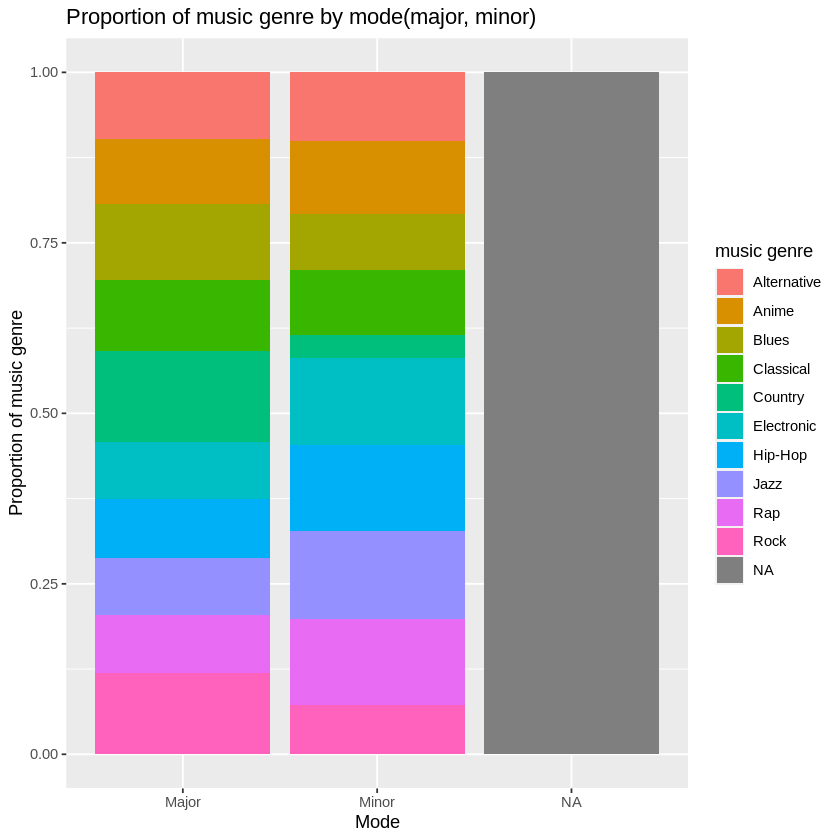

In [6]:
# proportion of music genre by mode(major, minor)
mode_proportion_plot <- data_train %>%
ggplot(aes(x = mode, fill = music_genre))+
geom_bar(position = "fill")+
labs(x = "Mode", y = "Proportion of music genre", fill = "music genre") +
ggtitle("Proportion of music genre by mode(major, minor)")
mode_proportion_plot

In [2]:
### Scale dataset

data_recipe <- recipe(music_genre ~ popularity + acousticness + danceability + 
                      duration_ms + energy + instrumentalness + liveness + loudness + 
                      speechiness + tempo + valence, data = data_train) %>%
   step_scale(all_predictors()) %>%
   step_center(all_predictors())
data_recipe
data_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) %>%
      set_engine("kknn") %>%
      set_mode("classification")
data_tune

ERROR: Error in recipe(music_genre ~ popularity + acousticness + danceability + : could not find function "%>%"


In [1]:
data_vfold <- vfold_cv(data_train, v = 5, strata = music_genre)
data_vfold

data_results <- workflow() %>%
      add_recipe(data_recipe) %>%
      add_model(data_tune) %>%
      tune_grid(resamples = data_vfold, grid = 10) %>%
      collect_metrics()
data_results

accuracies <- data_results %>% 
      filter(.metric == "accuracy")
accuracies
accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(x = "Neighbors", y = "Accuracy Estimate")
accuracy_versus_k

ERROR: Error in vfold_cv(data_train, v = 5, strata = music_genre): could not find function "vfold_cv"
